running on streamlit

### Imports

In [1]:
import streamlit as st
import yfinance as yf
import pandas as pd
import datetime as dt
import finnhub
from datetime import datetime
import time
import requests
from io import StringIO
from dotenv import load_dotenv
import os
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Set Symbol

In [17]:
# SBMO.AS ASML.AS BESI.AS ADYEN.AS NN.AS [MSFT MCD] NKE DIS  EURUSD=X GC=F
symbol = 'NN.AS'

### Option 1: Download the ticker data (via Yfinance)

In [18]:
# https://finance.yahoo.com/quote/NN.AS/history?p=NN.AS

# get today's date as a string in the required format
today = dt.datetime.today().strftime('%Y-%m-%d')

# Get data on this ticker
tickerData = yf.Ticker(symbol)

# get the required stock price history
df = tickerData.history(period='1d', start='2022-01-01', end=today,auto_adjust = False)

df = df.reset_index()

# convert the 'date' column to a datetime type
# df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['Date'] = pd.to_datetime(df['Date']).dt.tz_localize(None)
# df['Date'] = pd.to_datetime(df['Date'])

df.columns = df.columns.str.lower()
df = df.sort_values(by='date',ascending=True)

# extract only the date part
# df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

# Print the DataFrame
df.tail()

,date,open,high,low,close,adj close,volume,dividends,stock splits
595,2024-04-30,43.820000,43.880001,43.099998,43.349998,43.349998,865746,0.0,0.0
596,2024-05-02,43.599998,43.669998,43.029999,43.119999,43.119999,679336,0.0,0.0
597,2024-05-03,43.279999,43.570000,42.959999,43.150002,43.150002,618029,0.0,0.0
598,2024-05-06,43.349998,44.290001,43.320000,44.000000,44.000000,740957,0.0,0.0
599,2024-05-07,44.099998,45.070000,44.099998,45.000000,45.000000,882848,0.0,0.0


### Option 2: Download the ticker data via FinnHub (not working)

In [16]:
# https://analyzingalpha.com/finnhub-api-python-tutorial#:~:text=To%20call%20Finnhub%20API%20via,call%20Finnhub%20REST%20API%20functions.
# Stocks: MCD, MSFT, EURUSD=X

# *********** DO NOT USE ***********

# api_key = 'comhjphr01qp4op2kj1gcomhjphr01qp4op2kj20'
# api_key='colr6i9r01qqra7g7ongcolr6i9r01qqra7g7oo0'
api_key = 'chstmqpr01qr5oci5ujgchstmqpr01qr5oci5uk0'
finnhub_client = finnhub.Client(api_key=api_key)

In [17]:
symbol = symbol
interval = 'D'  # for daily stock candle values
start_date = '2023-10-01'  # 1609455600
end_date = '2024-04-10'  # 1612047600
today = datetime.today().strftime('%Y-%m-%d')

# Convert the date string to a datetime object
start_datetime = datetime.strptime(start_date, '%Y-%m-%d')
end_datetime = datetime.strptime(end_date, '%Y-%m-%d')
today_datetime = datetime.strptime(today, '%Y-%m-%d')

# Convert the datetime object to a Unix timestamp (seconds since epoch)
unix_start = int(time.mktime(start_datetime.timetuple()))
unix_end = int(time.mktime(end_datetime.timetuple()))
unix_today = int(time.mktime(today_datetime.timetuple()))

In [ ]:
response = finnhub_client.stock_candles(symbol,
                                        'D',  # Supported interval values are 1, 5, 15, 30, 60, D, W, M.
                                        unix_start,
                                        unix_end)  # Changed to unix_end (was unix_today)
df = pd.DataFrame(response)

# Convert Unix timestamp back to Date format
df['date'] = pd.to_datetime(df['t'], unit='s')
# Rearrange the columns
column_names = {'date': 'date', 'o': 'open', 'h': 'high', 'l': 'low', 'c': 'close', 'v': 'volume'}
df = df.rename(columns=column_names)

columns = ['date', 'open', 'high', 'low', 'close', 'volume']
df = df[columns]
df.head()

### Option 3: Download via Alpha Vantage! 

https://www.alphavantage.co/support/#api-key

In [122]:
# Example link: url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=IBM&outputsize=full&apikey=XXXXX&datatype=csv'

# Load environment variables
load_dotenv()

# Retrieve API key from environment
api_key = os.getenv('API_KEY')

# Function to build URL
def build_url(function, symbol, outputsize='full'):
    target = "https://www.alphavantage.co/query?"
    params = f"function={function}&symbol={symbol}&outputsize={outputsize}&apikey={api_key}&datatype=csv"
    return f"{target}{params}"

# Example usage
url = build_url('TIME_SERIES_DAILY', symbol)

# Request data
response = requests.get(url)
csv_data = StringIO(response.text)
df = pd.read_csv(csv_data)
column_names = {'timestamp': 'date'}
df = df.rename(columns=column_names)
df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
df = df.sort_values(by='date',ascending=True)
df.head()

,date,open,high,low,close,volume
6165,1999-11-01,25.31,26.06,24.94,25.69,7585800
6164,1999-11-02,25.56,26.31,25.50,26.25,6240800
6163,1999-11-03,27.38,27.38,26.69,26.88,8196800
6162,1999-11-04,27.75,29.00,26.00,26.50,13492400
6161,1999-11-05,25.50,25.50,24.06,24.31,26165000


In [99]:
df.tail()

,date,open,high,low,close,volume
4,2024-04-26,14.21,14.24,14.09,14.09,402837
3,2024-04-29,14.11,14.37,14.10,14.32,362786
2,2024-04-30,14.31,14.32,13.95,13.95,413817
1,2024-05-02,13.93,13.93,13.69,13.73,458060
0,2024-05-03,13.82,14.02,13.80,13.92,568259


### Option 4: Download the ticker data via https://polygon.io/ (not explored)

### Create a list with all gaps (>1 day)

In [134]:
all_gaps = pd.DataFrame(columns=['date', 'gap_size', 'from', 'to', 'gap_type'])


# Loop through the rows of the dataframe
for i in range(1, len(df)):
    prev_high = df.iloc[i-1]['high']
    prev_low = df.iloc[i-1]['low']
    curr_open = df.iloc[i]['open']
    curr_high = df.iloc[i]['high']
    curr_low = df.iloc[i]['low']
    gap_size = 0
    
    # Check for gap up
    if curr_low > prev_high:
        gap_size = curr_low - prev_high
        new_row = {'date': df.iloc[i]['date'], 'gap_size': gap_size, 'from': prev_high, 'to': curr_low, 'gap_type': 'up'}
        all_gaps = pd.concat([all_gaps, pd.DataFrame([new_row])], ignore_index=True)
            
    # Check for gap down
    elif curr_high < prev_low:
        gap_size = prev_low - curr_high
        new_row = {'date': df.iloc[i]['date'], 'gap_size': gap_size, 'from': prev_low, 'to': curr_high, 'gap_type': 'down'}
        all_gaps = pd.concat([all_gaps, pd.DataFrame([new_row])], ignore_index=True)

# Print the results
print(symbol)
print('count of all_gaps > 1 day: ', all_gaps['date'].count())
print("")
print(all_gaps)

SBMO.AS
count of all_gaps > 1 day:  38

         date      gap_size       from         to gap_type
0  2022-01-04  1.569635e-02  10.421473  10.437170       up
1  2022-01-12  1.569409e-02  10.900172  10.915866       up
2  2022-01-26  7.847674e-02  10.703983  10.782460       up
3  2022-02-10  5.885688e-02  11.374946  11.316089     down
4  2022-02-24  4.316110e-02  10.558805  10.515644     down
5  2022-03-17  7.846626e-03  10.853087  10.860934       up
6  2022-04-05  5.100894e-02  11.512276  11.563285       up
7  2022-04-25  1.002221e-01  11.709314  11.609092     down
8  2022-05-04  2.505714e-02  11.746896  11.771953       up
9  2022-06-10  7.099106e-02  12.323176  12.252185     down
10 2022-06-13  1.336290e-01  11.980749  11.847120     down
11 2022-08-04  5.011071e-02  11.458758  11.508869       up
12 2022-09-26  2.105555e-07  10.828193  10.828193     down
13 2022-10-04  8.352411e-03  11.120506  11.128859       up
14 2022-11-01  4.175939e-02  11.525573  11.567332       up
15 2022-12-27  2

### Create a list with same day gap closes

In [135]:
# Initialize a list to store the data
same_day_closes = []

# Loop through the rows of the dataframe
for i in range(1, len(df)):
    prev_high = df.iloc[i-1]['high']
    prev_low = df.iloc[i-1]['low']
    curr_open = df.iloc[i]['open']
    curr_high = df.iloc[i]['high']
    curr_low = df.iloc[i]['low']
    curr_close = df.iloc[i]['close']
    
    # Check for gap up and same day close within the previous day's high
    if curr_open > prev_high and curr_low <= prev_high:
        gap_size = curr_open - prev_high
        same_day_closes.append({'date': df.iloc[i]['date'], 'gap_size': gap_size})
        
    # Check for gap down and same day close within the previous day's low
    elif curr_open < prev_low and curr_high >= prev_low:
        gap_size = prev_low - curr_open
        same_day_closes.append({'date': df.iloc[i]['date'], 'gap_size': gap_size})

# Create DataFrame from the list of data
same_day_closes = pd.DataFrame(same_day_closes)

# Print the resulting DataFrame

print(symbol, 'same day gap closes:')
print("")
print(same_day_closes)


SBMO.AS same day gap closes:

          date  gap_size
0   2022-01-17  0.007848
1   2022-01-21  0.027466
2   2022-01-25  0.023544
3   2022-02-02  0.003923
4   2022-02-07  0.019618
..         ...       ...
131 2024-02-16  0.035986
132 2024-02-23  0.000001
133 2024-02-28  0.017993
134 2024-02-29  0.080967
135 2024-04-02  0.071971

[136 rows x 2 columns]


### Closed and Unclosed Gaps over time

In [125]:
# Initialize the DataFrames
closed_gaps = pd.DataFrame(columns=['closed_date', 'gap_start', 'gap_size', 'duration'])
open_gaps = all_gaps.copy()

# Initialize a list to collect new rows for closed_gaps
new_rows = []

# Loop through open_gaps DataFrame
for index, gap in open_gaps.iterrows():
    # Filter df based on gap start date and gap type
    if gap['gap_type'] == 'up':
        filtered_data = df[(df['date'] >= gap['date']) & (df['low'] <= gap['from'])]
    elif gap['gap_type'] == 'down':
        filtered_data = df[(df['date'] >= gap['date']) & (df['high'] >= gap['from'])]
    
    # Check if gap is closed
    if not filtered_data.empty:
        # Calculate duration
        duration = (filtered_data.iloc[0]['date'] - gap['date']).days
        # Collect the new row
        new_rows.append({
            'closed_date': filtered_data.iloc[0]['date'],
            'gap_start': gap['from'],
            'gap_size': gap['gap_size'],
            'duration': duration
        })
        # Drop row from open_gaps DataFrame
        open_gaps.drop(index, inplace=True)

# Concatenate all new rows to closed_gaps DataFrame in one operation
if new_rows:
    closed_gaps = pd.concat([closed_gaps, pd.DataFrame(new_rows)], ignore_index=True)

# Reset the index of open_gaps
open_gaps.reset_index(drop=True, inplace=True)
closed_gaps['duration'] = closed_gaps['duration'].astype(float)

print(symbol)
print('all_open_gaps:')
print(open_gaps)
print("")
print('all_closed_gaps:')
print(closed_gaps)

DIS
all_open_gaps:
         date  gap_size     from      to gap_type
0  2009-07-15     0.160   23.210   23.37       up
1  2009-07-16     0.230   24.130   24.36       up
2  2009-09-08     0.060   26.030   26.09       up
3  2009-11-04     0.170   27.730   27.90       up
4  2011-10-05     0.340   29.970   30.31       up
5  2011-11-30     0.160   34.500   34.66       up
6  2011-12-23     0.110   37.000   37.11       up
7  2012-01-03     0.140   37.800   37.94       up
8  2012-02-03     0.110   39.250   39.36       up
9  2012-06-06     0.080   44.920   45.00       up
10 2013-01-02     0.840   49.800   50.64       up
11 2013-01-17     0.060   51.780   51.84       up
12 2013-04-08     0.030   57.730   57.76       up
13 2013-09-10     0.095   61.835   61.93       up
14 2013-09-11     0.010   62.970   62.98       up
15 2013-10-10     0.110   64.180   64.29       up
16 2014-02-06     2.730   72.050   74.78       up
17 2021-09-20     1.850  182.730  180.88     down
18 2021-11-11     9.910  173.87

### Correlation

In [126]:
# Calculate the correlation
correlation = closed_gaps['gap_size'].corr(closed_gaps['duration'])

# Print the correlation
print('Correlation between gap_size and duration:', correlation)

Correlation between gap_size and duration: 0.15388211782408537


### Plot Gap Size vs. Duration

In [127]:
fig = go.Figure(data=go.Scatter(x=closed_gaps['duration'], y=closed_gaps['gap_size'], mode='markers'))

# Update layout
fig.update_layout(title=f'Scatter Plot of gap_size vs. duration {symbol}',
                  xaxis_title='Duration',
                  yaxis_title='Gap Size')

# Show the plot
fig.show()

### Gap statistics

In [128]:
total = len(same_day_closes) + len(all_gaps)
print("Ticker: ",symbol)
print("total number of gaps:", total)
print("total number same day closes:", len(same_day_closes))
print("total number true gaps:", len(all_gaps))
print("true gaps closed:", len(closed_gaps))
print("total number current open gaps:", len(open_gaps))
# print("gaps closed in current timeframe:", 1-(round(len(open_gaps) / total, 2)))
print("")
print("same day closes % :",len(same_day_closes)/total)
print("true_gaps % :",len(all_gaps)/total)
print("")
print("same day closes mean gap size:", round(same_day_closes.gap_size.mean(), 2))

print("largest same day gap close:", round(same_day_closes.gap_size.max(), 2))
print("")
print("true gaps mean gap size:", round(all_gaps.gap_size.mean(), 2))
print("true gaps max gap size:", round(all_gaps.gap_size.max(), 2))


# find the row index of the value in df that is closest to your variable
idx = (open_gaps['from'] - curr_close).abs().idxmin()
print("")
# extract the corresponding value from df
print('latest stock price', df['close'].iloc[-1])
nearest_gap = open_gaps['from'].iloc[idx]
nearest_gap_date = open_gaps['date'].iloc[idx]

# print the result
print("nearest gap: ",nearest_gap)
print("nearest gap date: ",nearest_gap_date.strftime('%Y-%m-%d'))

Ticker:  DIS
total number of gaps: 1736
total number same day closes: 1284
total number true gaps: 452
true gaps closed: 427
total number current open gaps: 25

same day closes % : 0.7396313364055299
true_gaps % : 0.26036866359447003

same day closes mean gap size: 0.29
largest same day gap close: 5.5

true gaps mean gap size: 0.67
true gaps max gap size: 10.03

latest stock price 113.66
nearest gap:  127.79
nearest gap date:  2022-04-20


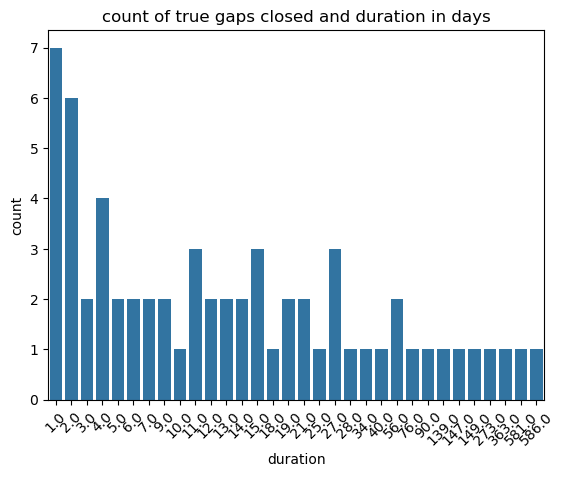

In [118]:
# Create countplot
sns.countplot(x='duration', data=closed_gaps)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.title("count of true gaps closed and duration in days")
# Show plot
plt.show()

In [129]:
all_gaps.to_csv('dis_gaps_alpha.csv', index=False)